In [8]:
import os
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import cv2


In [2]:
# 하이퍼파라미터
batch_size = 64
img_size = 48  # FER-2013이 보통 48x48
epochs = 30

train_dir = './data/train'
test_dir = './data/test'

# 증강(augmentation) 옵션 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 테스트셋은 보통 증강 없이 rescale만
test_datagen = ImageDataGenerator(rescale=1./255)

# flow_from_directory를 이용해 이미지 불러오기
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',  # 흑백 이미지 사용 시
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes  # 실제 분류할 감정 수(=5)
print("학습용 클래스(감정) 개수:", num_classes)
print("클래스 인덱스:", train_generator.class_indices)


Found 23308 images belonging to 5 classes.
Found 5834 images belonging to 5 classes.
학습용 클래스(감정) 개수: 5
클래스 인덱스: {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}


In [3]:
model = Sequential()

model.add(Input(shape=(img_size, img_size, 1)))  # 명시적으로 입력 정의
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # 오버피팅 방지
model.add(Dense(num_classes, activation='softmax'))  # 5개 감정을 분류

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,357 (1.36 MB)

 Trainable params: 355,973 (1.36 MB)

 Non-trainable params: 384 (1.50 KB)

In [5]:
import math

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True
).repeat()

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=False
)

history = model.fit(
    train_ds,
    steps_per_epoch=math.ceil(train_generator.samples / batch_size),
    epochs=epochs,
    validation_data=val_ds,
    verbose=2
)


Found 23308 files belonging to 5 classes.
Found 5834 files belonging to 5 classes.
Epoch 1/30
365/365 - 15s - 42ms/step - accuracy: 0.4247 - loss: 1.3637 - val_accuracy: 0.4443 - val_loss: 1.3277
Epoch 2/30
365/365 - 15s - 41ms/step - accuracy: 0.4636 - loss: 1.2838 - val_accuracy: 0.4834 - val_loss: 1.2645
Epoch 3/30
365/365 - 15s - 42ms/step - accuracy: 0.4976 - loss: 1.2136 - val_accuracy: 0.5000 - val_loss: 1.2243
Epoch 4/30
365/365 - 16s - 43ms/step - accuracy: 0.5257 - loss: 1.1592 - val_accuracy: 0.5141 - val_loss: 1.1781
Epoch 5/30
365/365 - 15s - 41ms/step - accuracy: 0.5499 - loss: 1.1029 - val_accuracy: 0.5283 - val_loss: 1.1567
Epoch 6/30
365/365 - 15s - 42ms/step - accuracy: 0.5721 - loss: 1.0579 - val_accuracy: 0.5447 - val_loss: 1.1299
Epoch 7/30
365/365 - 15s - 41ms/step - accuracy: 0.5883 - loss: 1.0154 - val_accuracy: 0.5593 - val_loss: 1.0988
Epoch 8/30
365/365 - 15s - 40ms/step - accuracy: 0.6031 - loss: 0.9804 - val_accuracy: 0.5626 - val_loss: 1.0909
Epoch 9/30
36

In [6]:
# 모델 저장 (원하는 경로로)
model.save('emotion_model.keras')

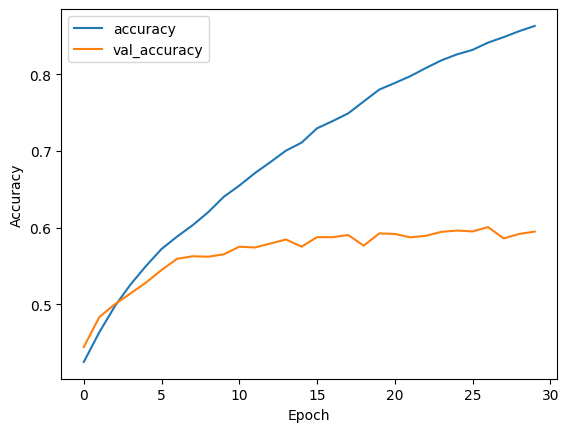

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# ----- 1. 학습된 모델 로드 -----
# 경로는 본인이 저장한 모델 경로로 맞춰주세요.
model = tf.keras.models.load_model('emotion_model.keras')

# 감정 레이블
emotion_labels = ['angry', 'fear', 'happy', 'sad', 'surprise']

# ----- 2. 웹캠 열기 -----
cap = cv2.VideoCapture(0)  # 0번 디바이스(기본 웹캠)

if not cap.isOpened():
    print("카메라 열기 실패")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("프레임 읽기 실패")
        break

    # ----- 3. 얼굴 인식(선택사항) -----
    # 직접 얼굴을 잘라내고 싶으면 OpenCV Cascade/MTCNN 등을 사용하여
    # 얼굴 영역만 crop 후 resize해서 모델에 넣을 수도 있습니다.
    # 여기서는 간단히 전체 프레임으로 처리한다고 가정.

    # ----- 4. 전처리 -----
    # (a) 그레이 스케일 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # (b) 모델에 맞는 사이즈로 resize (48x48)
    resized = cv2.resize(gray, (48, 48))

    # (c) 정규화(Scaling)
    img_array = resized.astype('float32') / 255.0

    # (d) 배치 차원 추가 (batch, height, width, channel)
    img_array = np.expand_dims(img_array, axis=-1)  # (48,48) -> (48,48,1)
    img_array = np.expand_dims(img_array, axis=0)   # -> (1,48,48,1)

    # ----- 5. 모델 예측 -----
    # 결과 shape: (1, 5)
    predictions = model.predict(img_array)[0]  # (5,) 형태

    # ----- 6. 예측 결과 로깅(출력) -----
    # 5개 감정 각각의 확률 (Softmax 값)을 표시
    # 로그만 찍고 싶다면 print 문을 사용
    # (아래는 소수점 세 자리까지 표시 예시)
    log_str = " | ".join([f"{emotion_labels[i]}: {predictions[i]:.3f}"
                          for i in range(len(emotion_labels))])
    print(f"[LOG] {log_str}")

    # ----- 7. 프레임에 감정 결과 표시 (선택사항) -----
    # 가장 확률이 높은 감정을 텍스트로 표시할 수 있음
    max_index = np.argmax(predictions)
    max_emotion = emotion_labels[max_index]
    max_prob = predictions[max_index]
    cv2.putText(frame, f"{max_emotion} ({max_prob:.2f})",
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # ----- 8. 화면에 프레임 띄우기 (선택) -----
    cv2.imshow('Real-time Emotion Recognition', frame)

    # q 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 자원 정리
cap.release()
cv2.destroyAllWindows()


C:\Users\SSAFY\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[LOG] angry: 0.621 | fear: 0.127 | happy: 0.002 | sad: 0.028 | surprise: 0.222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[LOG] angry: 0.621 | fear: